In [28]:
# necessary imports

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# tunembed_dfs = []
#
# for decade in range(20, 100, 10):
#     tunem_df = pd.read_csv('tunedembeddings_results/precocity_econ_19' + str(decade) + 's_docs.tsv', sep = '\t')
#     tunembed_dfs.append(tunem_df)
#     print(tunem_df.shape, decade)

In [30]:
# tunem_df.head()

In [31]:
# tunedEmbeddings = pd.concat(tunembed_dfs, axis = 0)
# tunedEmbeddings.head()

In [32]:
"""
Read in the metadata and merge with the novelty data
"""

data_dir = 'econ_data/precocity'
all_dfs = []

import pandas as pd
import os
import re
# Load metadata
df_meta = pd.read_csv('econ_data/econ_metadata/all-econ-S2metaWyearcol.tsv', sep='\t')
# Load all paper data files
print("Reading data files...")
for file in os.listdir(data_dir):
    if file.endswith('.tsv'):
        match = re.search(r'(\d{4})', os.path.basename(file))
        year = match.group(1) if match else 'unknown'
        # print(f"Processing {csv} (year: {year})")
        path = os.path.join(data_dir, file)
        df = pd.read_csv(path, sep='\t')
        df['paperId'] = df['docid']
        df['decade'] = year
        merged = df_meta.merge(df, on='paperId', how='left')
        all_dfs.append(merged)


gender_meta = pd.read_csv('econ_data/author_gender_econ.csv')
#read in the gender data we have already


Reading data files...


In [33]:
# meta = pd.read_csv("all-econ-S2metaWyearcol.tsv", sep = '\t')
print(len(df_meta))
df_meta.rename(columns={'paperId': 'docid'}, inplace=True)
df_meta.set_index('docid', inplace = True)
rschmeta = df_meta.loc[df_meta.docSubType == 'research-article', : ]
print(len(rschmeta))
bkrvmeta = df_meta.loc[df_meta.docSubType == 'book-review', : ]
print(len(bkrvmeta))

43187
41378
1809


In [34]:
#clean up the gender data
gender_meta = gender_meta[gender_meta['gender'].isin(['male', 'female'])]


In [35]:
#put all the decades together

import pandas as pd

df_all = pd.concat(all_dfs, ignore_index=True)

In [36]:
# "deduplicate the data by selecting one set of parameters ted recommended"
#
# #filter for only male/female gender and also for the single set of novelty results (time chunks etc)
#
# #chunks_used
#     #use 0.25 (top 25% most novel chunks)
# df_all = df_all.loc[df_all['chunks_used'] == 0.25]
#
# #time_radius
#     #use 20
# df_all = df_all.loc[df_all['time_radius'] == 20]
#
#
# #filtered
#     #use trainauthquote
# df_all = df_all.loc[df_all['filtered'] == 'trainauthquote']
#
#
#
# #fraction_compared
#     #10 percent most similar vs all articles... use all articles aka 1.0
#
# df_all = df_all.loc[df_all['fraction_compared'] == 1.0]
#
#
# #num_chunks
#     #I don't think this one needed to be filtered?

In [37]:
#apply gender dict
gender_dict = pd.Series(gender_meta['gender'].values, index=gender_meta['author']).to_dict()
df_all['gender'] = df_all['creator'].map(gender_dict).fillna('unknown')


In [38]:
# # author_groups = {}
# #
# # for author, group in df_all.groupby('authors'):
# #     papers = group[['title','citation_counts','novelty','precocity','year']].to_dict(orient='records')
# #     gender = group['gender'].iloc[0]
# #     author_groups[author] = {
# #         "gender": gender,
# #         "papers": papers
# #     }
#
# author_groups = {}
#
# # Make sure 'authors' is a string per row
# df_all['author_str'] = df_all['creator'].apply(
#     lambda x: x[0] if isinstance(x, list) and len(x) == 1 else ", ".join(x) if isinstance(x, list) else x
# )
#
# for author, group in df_all.groupby('author_str'):
#     papers = group[['title', 'isPartOf','citationCount', 'novelty', 'precocity', 'year']].to_dict(orient='records')
#
#     gender = group['gender'].iloc[0] if 'gender' in group.columns else 'unknown'
#
#     author_groups[author] = {
#         "gender": gender,
#         "papers": papers
#     }
#


In [39]:
# #flatten data for regression analysis
#
# import pandas as pd
#
# rows = []
# for author, data in author_groups.items():
#     for paper in data['papers']:
#         row = {"author": author, "gender": data['gender'], **paper}
#         rows.append(row)
#
# df_flat = pd.DataFrame(rows)


# Controlled regression over time

In [40]:
# A function that models the predictive effect of precocity on log(citations),
# while controlling for the effect of time.

def controlled_model(reg_df):

    X = []
    for idx, row in reg_df.iterrows():
        newrow = dict()
        newrow['precocity'] = row['precocity']
        newrow['novelty'] = row['novelty']
        newrow['precocity^2'] = row['precocity'] ** 2
        newrow['logcitations'] = row['logcitations']
        for yr in range(1920, 2000, 5):
            col = 'year' + str(yr)
            if col == 'year1940':
                continue
            if (row['date'] >= yr) and (row['date'] < yr + 5):
                newrow[col] = 1
            else:
                newrow[col] = 0
        X.append(newrow)

    X = pd.DataFrame(X)

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Define the dependent variable
    y = X['logcitations']

    X = X.drop('logcitations', axis=1)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model
    print(model.summary())

def model_novelty_and_transience(reg_df):

    X = []
    for idx, row in reg_df.iterrows():
        newrow = dict()
        newrow['transience'] = row['transience']
        newrow['novelty'] = row['novelty']
        newrow['novelty^2'] = row['novelty'] ** 2
        newrow['transience^2'] = row['transience'] ** 2
        newrow['logcitations'] = row['logcitations']
        for yr in range(1920, 2000, 5):
            col = 'year' + str(yr)
            if (row['date'] >= yr) and (row['date'] < yr + 5):
                newrow[col] = 1
            else:
                newrow[col] = 0
        X.append(newrow)

    X = pd.DataFrame(X)

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Define the dependent variable
    y = X['logcitations']

    X = X.drop('logcitations', axis=1)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model
    print(model.summary())

In [41]:
# We also need a function to visualize results over time 

def visualize_results(rlist, ryears):
    df = pd.DataFrame({'year': ryears, 'correlation': rlist})

    minvalue = 0 if min(df['correlation']) >= 0 else min(df['correlation']) - 0.02

    plt.figure(figsize=(10, 6))
    sns.lineplot(df, x='year', y='correlation', marker='o')

    plt.xlabel('Year')
    plt.ylabel('Correlation of precocity with log(citations)')
    plt.title('Strength of correlation')

    plt.ylim(minvalue, max(df['correlation']) + 0.02)

    if minvalue < 0:
        plt.axhline(0, linestyle='--', color='red')

    plt.show()

1920 - 20/0.25/1, n = 1229, -0.05744
1930 - 20/0.25/1, n = 1412, 0.0962
1940 - 20/0.25/1, n = 1545, -0.09886
1950 - 20/0.25/1, n = 3275, 0.0849
1960 - 20/0.25/1, n = 4319, 0.19576
1970 - 20/0.25/1, n = 7272, 0.2009
1980 - 20/0.25/1, n = 6777, 0.20451
1990 - 20/0.25/1, n = 4426, 0.23997


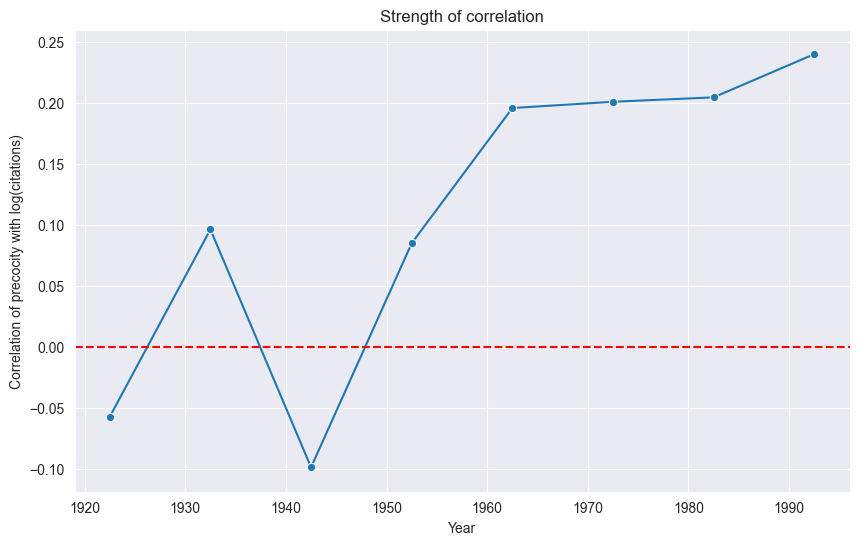

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     764.8
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:50:12   Log-Likelihood:                -58693.
No. Observations:               30255   AIC:                         1.174e+05
Df Residuals:                   30236   BIC:                         1.176e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6768      0.067     25.059      

In [47]:
meta = df_meta

def run_model(path_to_model, metadata, chunksused = 0.25, fractioncompared = 1.0):
    precocity = []
    novelty = []
    transience = []
    date = []
    logcitations = []
    docids = []
    rlist = []
    ryears = []

    for decade in range(1920, 2000, 10):
        
        data = pd.read_csv(path_to_model + 'precocity_econ_' + str(decade) + 's_docs.tsv', sep = '\t')

        data.set_index('docid', inplace=True)

        data = data.join(metadata['citationCount'], how='inner')
        data['logcitations'] = np.log(data.citationCount + 1)

        selected = data.loc[(data.time_radius == 20) & (data.filtered == 'trainauthquote') &
            (data.chunks_used == chunksused) & (data.fraction_compared == fractioncompared), :]
        
        r, p = pearsonr(selected.logcitations, selected.precocity)
        print(f"{decade} - 20/{chunksused}/{fractioncompared}, n = {selected.shape[0]}, {round(r, 5)}")

        precocity.extend(selected.precocity.values.tolist())
        novelty.extend(selected.novelty.values.tolist())
        transience.extend(selected.transience.values.tolist())
        date.extend(selected.date.values.tolist())
        logcitations.extend(selected.logcitations.values.tolist())
        docids.extend(selected.index.tolist())

        rlist.append(r)
        ryears.append(decade + 2.5)

    visualize_results(rlist, ryears)
    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'transience': transience, 
                           'date': date, 'logcitations': logcitations, 'docid': docids})
    controlled_model(reg_df)
    return reg_df

reg_df = run_model('econ_data/precocity/', meta, chunksused = 0.25, fractioncompared = 1)

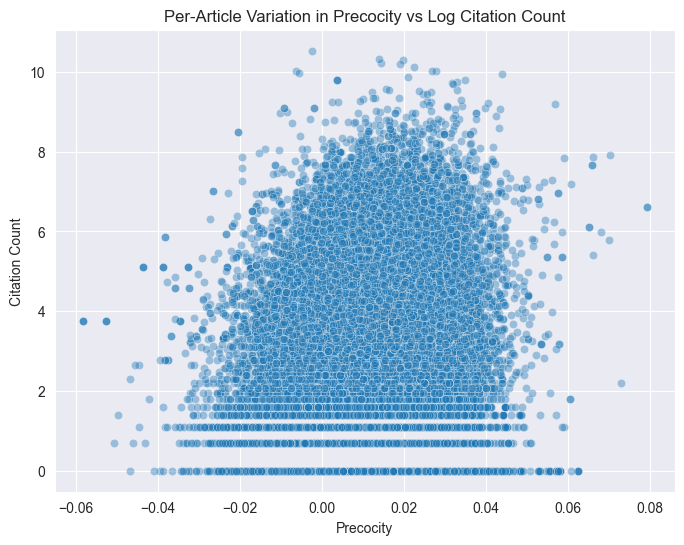

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=reg_df, x="precocity", y="logcitations", alpha=0.4)
plt.xlabel("Precocity")
plt.ylabel("Citation Count")
plt.title("Per-Article Variation in Precocity vs Log Citation Count")
plt.show()


In [8]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     807.4
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:49:21   Log-Likelihood:                -59273.
No. Observations:               30255   AIC:                         1.186e+05
Df Residuals:                   30239   BIC:                         1.187e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6956      0.065     25.944      

In [114]:
#model_novelty_and_transience(reg_df)

In [115]:
## Difference between R^2 of model and null model = 0.313 - 0.286 = 0.027

# Running just research articles

#### top 25% of chunks:

1920 - 20/0.25/1, n = 1115, -0.06064
1930 - 20/0.25/1, n = 1389, 0.09615
1940 - 20/0.25/1, n = 1520, -0.09655
1950 - 20/0.25/1, n = 2593, 0.10602
1960 - 20/0.25/1, n = 4173, 0.19912
1970 - 20/0.25/1, n = 7215, 0.19808
1980 - 20/0.25/1, n = 6750, 0.20382
1990 - 20/0.25/1, n = 4409, 0.24396


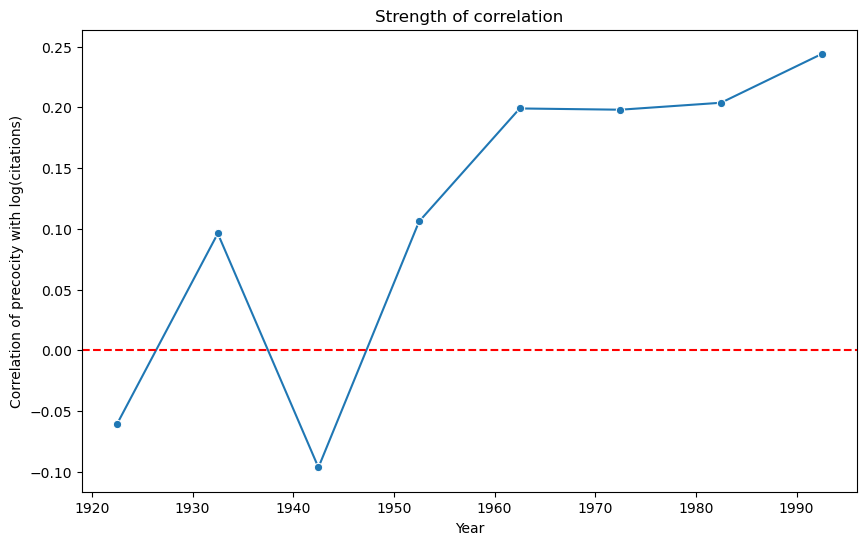

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     741.9
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:53:17   Log-Likelihood:                -56420.
No. Observations:               29164   AIC:                         1.129e+05
Df Residuals:                   29145   BIC:                         1.130e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7028      0.068     25.048      

In [14]:
reg_df = run_model('tunedembeddings_results/precocity_econ_', rschmeta, chunksused = 0.25, fractioncompared = 1)

In [15]:
model_novelty_and_transience(reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     715.2
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:53:30   Log-Likelihood:                -56340.
No. Observations:               29164   AIC:                         1.127e+05
Df Residuals:                   29144   BIC:                         1.129e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.4898      0.026     94.830   

In [16]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     774.1
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:54:10   Log-Likelihood:                -57031.
No. Observations:               29164   AIC:                         1.141e+05
Df Residuals:                   29148   BIC:                         1.142e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6970      0.066     25.582      

# Diff for 25% chunks is 0.314 - 0.285 = 0.029

#### all chunks:

1920 - 20/1/1, n = 1115, -0.09276
1930 - 20/1/1, n = 1389, 0.0857
1940 - 20/1/1, n = 1520, -0.11508
1950 - 20/1/1, n = 2593, 0.0511
1960 - 20/1/1, n = 4173, 0.13787
1970 - 20/1/1, n = 7215, 0.15932
1980 - 20/1/1, n = 6750, 0.17213
1990 - 20/1/1, n = 4409, 0.1952


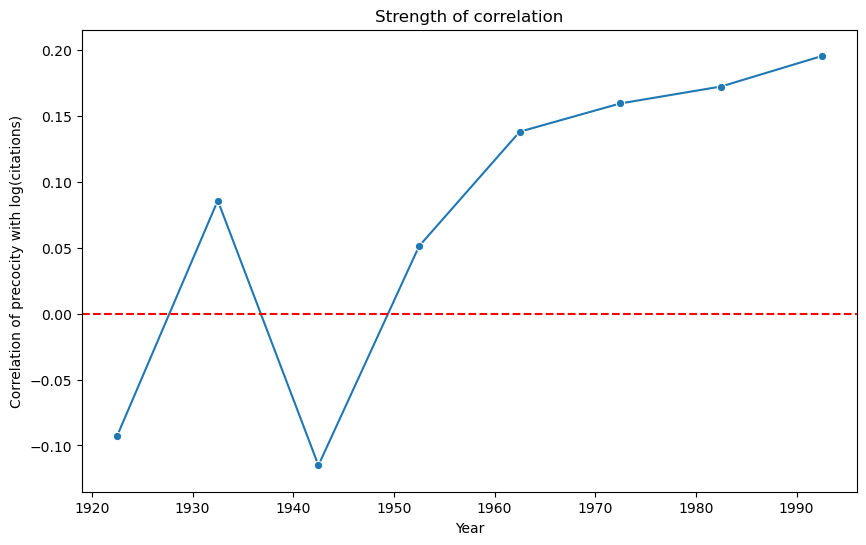

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     705.0
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:51:48   Log-Likelihood:                -56650.
No. Observations:               29164   AIC:                         1.133e+05
Df Residuals:                   29145   BIC:                         1.135e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9626      0.068     28.709      

In [11]:
reg_df = run_model('tunedembeddings_results/precocity_econ_', rschmeta, chunksused = 1, fractioncompared = 1)

In [12]:
model_novelty_and_transience(reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     675.6
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:52:10   Log-Likelihood:                -56598.
No. Observations:               29164   AIC:                         1.132e+05
Df Residuals:                   29144   BIC:                         1.134e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.7042      0.026    104.564   

In [13]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     774.1
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:52:14   Log-Likelihood:                -57031.
No. Observations:               29164   AIC:                         1.141e+05
Df Residuals:                   29148   BIC:                         1.142e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6970      0.066     25.582      

# Diff for all chunks is 0.303 - 0.285 = 0.018

# Running just book reviews

In [75]:
bkrvmeta = meta.loc[meta.docSubType == 'book-review', : ]
print(len(bkrvmeta))

1809


1920 - 20/0.25/1.0, n = 114, 0.0088
1930 - 20/0.25/1.0, n = 23, 0.23392
1940 - 20/0.25/1.0, n = 25, -0.23717
1950 - 20/0.25/1.0, n = 682, -0.02497
1960 - 20/0.25/1.0, n = 146, 0.015
1970 - 20/0.25/1.0, n = 57, -0.11337
1980 - 20/0.25/1.0, n = 27, 0.05568
1990 - 20/0.25/1.0, n = 17, -0.51282


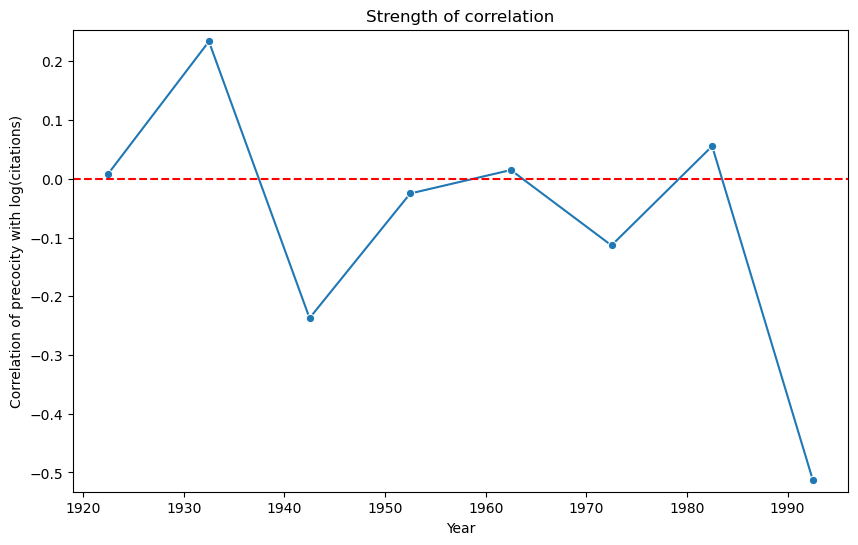

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.154
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           1.60e-05
Time:                        20:13:00   Log-Likelihood:                -2189.0
No. Observations:                1091   AIC:                             4414.
Df Residuals:                    1073   BIC:                             4504.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6182      0.376      4.307      

In [76]:
reg_df = run_model('tunedembeddings_results/precocity_econ_', bkrvmeta, chunksused = 0.25, fractioncompared = 1.0)